In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from scipy.stats import norm
import math
import warnings
warnings.simplefilter('ignore', category=RuntimeWarning)
from scipy.special import beta
from decimal import *

In [2]:
class Agent:
  def __init__(self, E, arm_times, arm_random_p, arm_size):
    self.E = E
    self.arm_times = arm_times
    self.arm_random_p = arm_random_p
    self.arm_size = arm_size
  
  def initialize(self):
    self.E = np.array([0.5] * self.arm_size)
    self.arm_times = np.array([10**-7] * self.arm_size)
    self.arm_random_p = np.array([0] * self.arm_size)

  def updata(self, reward, action):
    self.arm_times[action] += 1

    #報酬
    a = 1/(self.arm_times[action])
    self.E[action] = (1-a) * self.E[action] + a * reward

  def random_prob(self, size):
    self.arm_random = np.random.rand(size)
    return self.arm_random

  def reward(self, p, action):
    if random.random() < p[action]:
      return 1.0
    else:
      return 0.0    

################################################
class Agent_TS:
  def __init__(self, E, arm_times, arm_random_p, arm_size):
    self.E = E
    self.arm_times = arm_times
    self.arm_random_p = arm_random_p
    self.success = np.zeros(len(E))
    self.fail = np.zeros(len(E))
    self.arm_size = arm_size
  
  def initialize(self):
    self.E = np.array([0.5] * self.arm_size)
    self.arm_times = np.array([10**-7] * self.arm_size)
    self.arm_random_p = np.array([0] * self.arm_size)
    self.success = np.zeros(self.arm_size)
    self.fail = np.zeros(self.arm_size)

  def updata(self, reward, action):
    self.arm_times[action] += 1
    #報酬
    self.E = ((self.arm_times[action]-1)/self.arm_times[action])*self.E + (1/self.arm_times[action]) * reward
    if reward == 1:
      self.success[action] = self.success[action] +1
    elif reward == 0:
      self.fail[action] = self.fail[action] + 1

  def random_prob(self, size):
    self.arm_random = np.random.rand(size)
    return self.arm_random

  def reward(self, p, action):
    if random.random() < p[action]:
      return 1.0
    else:
      return 0.0    

#方策

In [3]:
######################################
class SRS:
  def __init__(self, p, epsilon):
    self.aleph = p.max()
    self.epsilon = epsilon

  def select_arm(self, E, arm_times, N, agent):
    if  E.max() > self.aleph:
      E = E - E.max() + self.aleph - self.epsilon

    Z = 1/(np.sum(1/(self.aleph - E)))
    row = Z / (self.aleph - E)

    b = (arm_times / row) - N + self.epsilon
    # b = (N * row - arm_times)/row

    SRS = (N + b.max()) * row - arm_times
    pi = SRS/np.sum(SRS)
    return np.random.choice(len(pi),p=pi)

######################################
class SRS_CH:
  def __init__(self, p, epsilon):
    self.aleph = 1.0
    self.epsilon = epsilon

  def select_arm(self, E, arm_times, N, agent):
    E_max = E.max()
    Dkl  = E*np.log(E/E_max) + (1-E)*np.log((1-E)/(1-E_max))
    myu = np.exp((-1)*arm_times*Dkl)
    aleph = np.nan_to_num(E_max*((1-(E/E_max)*myu)/(1-myu)),nan=0)
    aleph_ch = max(aleph)
    # print("aleph_ch = ",aleph_ch)

    if  E.max() > aleph_ch:
      E = E - E.max() + self.aleph - self.epsilon

    Z = 1/(np.sum(1/(aleph_ch - E)))
    row = Z / (aleph_ch - E)
    b = (arm_times / row) - N + self.epsilon

    SRS = (N + b.max()) * row - arm_times

    pi = SRS/np.sum(SRS)
    arm_count = np.zeros(len(E))
    for i in range(1000):
      action = np.random.choice(len(pi),p=pi)
      arm_count[action] += 1  

    return np.random.choice(len(pi),p=pi), arm_count

######################################
class SRS_OPT:
  def __init__(self, p, epsilon):
    p = sorted(p,reverse=True)
    self.aleph = (p[0] + p[1])/2
    self.epsilon = epsilon

  def select_arm(self, E, arm_times, N, agent):
    if  E.max() > self.aleph:
      E = E - E.max() + self.aleph - self.epsilon

    Z = 1/(np.sum(1/(self.aleph - E)))
    row = Z / (self.aleph - E)

    b = (arm_times / row) - N + self.epsilon

    SRS = (N + b.max()) * row - arm_times

    pi = SRS/np.sum(SRS)

    arm_count = np.zeros(len(E))
    for i in range(1000):
      action = np.random.choice(len(pi),p=pi)
      arm_count[action] += 1
    return np.random.choice(len(pi),p=pi), arm_count

# getcontext().prec = 8
# Decimal(1234567654321)
######################################
class RS:
  def __init__(self, p, epsilon):
    self.aleph = p.max()
    self.epsilon = epsilon

  def select_arm(self, E, arm_times, N, agent):
    RS = (arm_times / N)*(E - self.aleph)
    
    return np.argmax(RS)

######################################
class RS_OPT:
  def __init__(self, p, epsilon):
    p = sorted(p,reverse=True)
    self.aleph = (p[0] + p[1])/2
  
  def select_arm(self, E, arm_times, N, agent):
    RS = (arm_times / N)*(E - self.aleph)
    
    return np.argmax(RS)

######################################
class RS_CH:
  def __init__(self, p, epsilon):
    self.epsilon = epsilon

  def select_arm(self, E, arm_times, N, agent):
    E_max = E.max()
    DKL = E*np.log(E/E_max) + (1-E)*np.log((1-E)/(1-E_max))
    myu_ch_list = np.exp((-1)*arm_times*DKL)
    aleph = np.nan_to_num(E_max*(1-(E*myu_ch_list/E_max))/(1-myu_ch_list), nan=0)
    updata_aleph = aleph.max()
    RS = (arm_times/N)*(E - updata_aleph)

    if len(aleph) == 2:
      return np.argmax(RS)

    else:
      greedy = np.argmax(E)
      #RS
      a = [i for i,x in enumerate(RS) if RS[greedy] < RS[i]]
      # print("a = ",a)
      if len(a) == 0:
        return greedy
      elif len(a) == 1:
        return a
      elif len(a) >=2:
        #μ
        b = [i for i in a if myu_ch_list[greedy] < myu_ch_list[i]]
        # print("b = ",b)
        if len(b) == 0:
          return greedy
        elif len(b) == 1:
          return b
        elif len(b) >=2:
          #ℵ
          c = [i for i in b if aleph[greedy] < aleph[i]]
          # print("c = ",c)
          if len(c) == 0:
            return greedy
          elif len(c) == 1:
            return c
          elif len(c) >= 2:
            return np.random.choice(c)

######################################
class TS:
  def __init__(self, p, epsilon):
    self.p = p
  
  def select_arm(self, E, arm_times, N, agent):
    myu = np.array([np.random.beta(agent.success[action]+1, agent.fail[action]+1) for action in range(agent.arm_size)])
    return np.argmax(myu)

In [4]:
class Simulater:
  def __init__(self, n_sim, steps, arm_size, p, epsilon):
    self.steps = steps
    self.n_sim = n_sim
    self.arm_size = arm_size
    self.epsilon = epsilon
    self.p = np.array(p)
  
  def test(self, policy, Agent):
    agent = Agent(np.array([0.5]*self.arm_size), np.array([10**-7]*self.arm_size), np.zeros(self.arm_size), self.arm_size)
    regret = np.zeros((self.n_sim, self.steps))
    count_arm = np.zeros((self.steps, self.arm_size))

    for sim in range(self.n_sim):
      # p = agent.random_prob(self.arm_size)
      p = self.p
      pi = policy(p, self.epsilon)
      for step in tqdm(range(0, self.steps)):
        action, count = pi.select_arm(agent.E, agent.arm_times, step+1, agent)
        reward = agent.reward(p,action)
        agent.updata(reward, action)
        regret[sim, step] += regret[sim, step-1] + np.max(p) - p[action]
        count_arm[step] = count
      agent.initialize()
    return regret, count_arm

## 確率

100%|██████████| 6000/6000 [04:03<00:00, 24.61it/s]


p=0.2
 [0.518 1.    0.    0.    0.257 0.197 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ] 


p=0.8
 [0.482 0.    1.    1.    0.743 0.803 1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    0.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.  

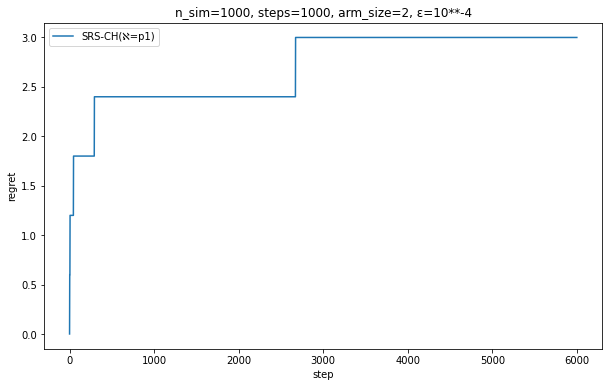

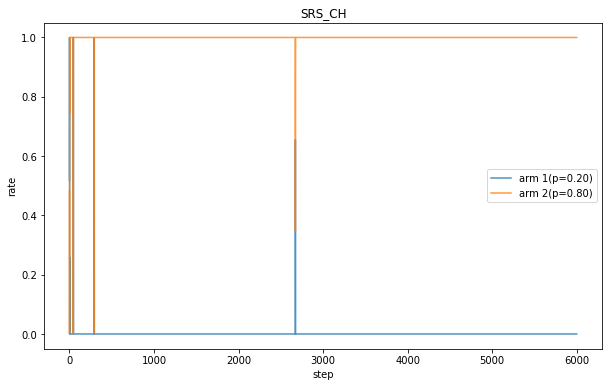

In [5]:
# p = [0.2, 0.8]
steps = 6000
simulata = Simulater(n_sim=1, steps=steps, arm_size=2, p = [0.2,0.8], epsilon=10**-4)
regeret_SRS_CH, count_SRS =  simulata.test(SRS_CH, Agent)

arm_1_srs_ch = np.zeros(steps)
arm_2_srs_ch = np.zeros(steps)

for j in range(steps):
  arm_1_srs_ch[j] = count_SRS[j][0]/1000
  arm_2_srs_ch[j] = count_SRS[j][1]/1000

# 選択確率
print("p=0.2\n",arm_1_srs_ch[:100],"\n\n")
print("p=0.8\n",arm_2_srs_ch[:100])

plt.figure(figsize=(10,6))
plt.xlabel("step")
plt.ylabel("regret")
plt.plot(np.mean(regeret_SRS_CH, axis=0), label="SRS-CH(ℵ=p1)")
plt.title("n_sim=1000, steps=1000, arm_size=2, ε=10**-4")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.xlabel("step")
plt.ylabel("rate")
plt.plot(arm_1_srs_ch, label = "arm 1(p=0.20)", alpha = 0.8)
plt.plot(arm_2_srs_ch, label = "arm 2(p=0.80)", alpha = 0.8)
plt.title("SRS_CH")
plt.legend()
plt.show()

100%|██████████| 6000/6000 [03:56<00:00, 25.39it/s]


p=0.45
 [0.48  0.    0.513 0.    0.    0.    1.    1.    0.497 0.    0.485 1.
 0.505 1.    0.509 0.    0.    0.    0.    0.999 0.    1.    1.    1.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    1.    1.    0.    1.    0.    0.    0.    0.
 1.    1.    1.    1.    1.    0.    0.    0.    0.    0.    1.    0.
 0.    0.    0.    0.   ] 


p=0.55
 [0.52  1.    0.487 1.    1.    1.    0.    0.    0.503 1.    0.515 0.
 0.495 0.    0.491 1.    1.    1.    1.    0.001 1.    0.    0.    0.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.

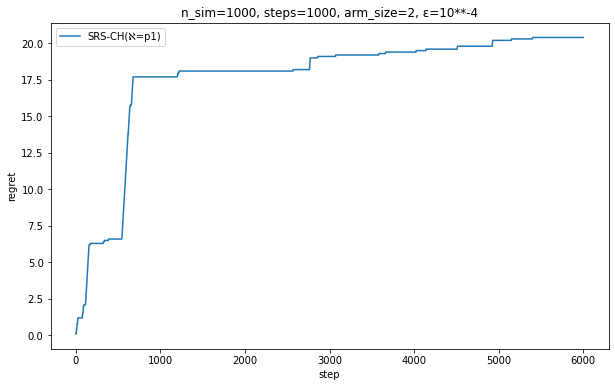

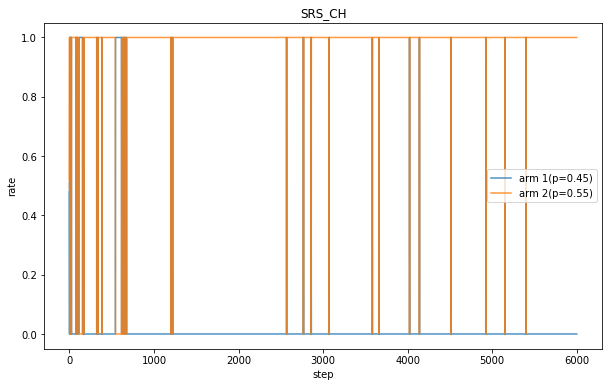

In [7]:
# p = [0.45, 0.55]
steps = 6000
simulata = Simulater(n_sim=1, steps=steps, arm_size=2, p = [0.45, 0.55], epsilon=10**-4)
regeret_SRS_CH, count_SRS =  simulata.test(SRS_CH, Agent)

arm_1_srs_ch = np.zeros(steps)
arm_2_srs_ch = np.zeros(steps)

for j in range(steps):
  arm_1_srs_ch[j] = count_SRS[j][0]/1000
  arm_2_srs_ch[j] = count_SRS[j][1]/1000

# 選択確率
print("p=0.45\n",arm_1_srs_ch[:100],"\n\n")
print("p=0.55\n",arm_2_srs_ch[:100])

plt.figure(figsize=(10,6))
plt.xlabel("step")
plt.ylabel("regret")
plt.plot(np.mean(regeret_SRS_CH, axis=0), label="SRS-CH(ℵ=p1)")
plt.title("n_sim=1000, steps=1000, arm_size=2, ε=10**-4")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.xlabel("step")
plt.ylabel("rate")
plt.plot(arm_1_srs_ch, label = "arm 1(p=0.45)", alpha = 0.8)
plt.plot(arm_2_srs_ch, label = "arm 2(p=0.55)", alpha = 0.8)
plt.title("SRS_CH")
plt.legend()
plt.show()

100%|██████████| 6000/6000 [03:56<00:00, 25.38it/s]


p=0.50
 [0.451 0.    1.    1.    0.752 0.808 0.831 0.    1.    0.642 0.    0.
 0.    0.999 1.    0.    0.    0.    0.465 1.    0.5   1.    0.    1.
 0.497 0.    0.    1.    0.    1.    0.504 0.    0.488 1.    1.    1.
 1.    0.    0.    0.    0.523 1.    0.488 1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 0.    1.    0.    0.    1.    1.    0.    1.    1.    1.    1.    1.
 0.    0.    0.    0.    0.    0.    1.    1.    1.    0.    0.    0.
 0.    0.999 1.    1.    1.    0.    1.    0.    0.    0.    0.    0.
 0.001 0.001 0.    0.   ] 


p=0.51
 [0.549 1.    0.    0.    0.248 0.192 0.169 1.    0.    0.358 1.    1.
 1.    0.001 0.    1.    1.    1.    0.535 0.    0.5   0.    1.    0.
 0.503 1.    1.    0.    1.    0.    0.496 1.    0.512 0.    0.    0.
 0.    1.    1.    1.    0.477 0.    0.512 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 1.    0.    1.    1.    0.    0.    1.    0.

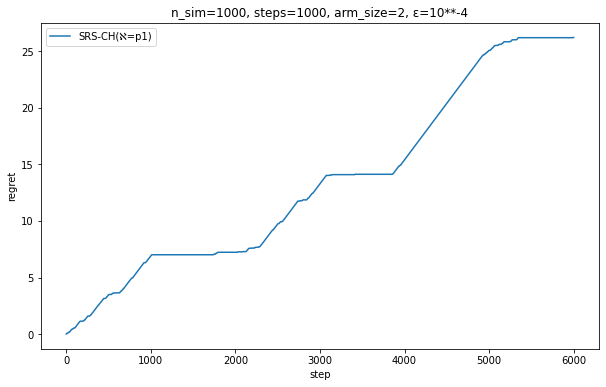

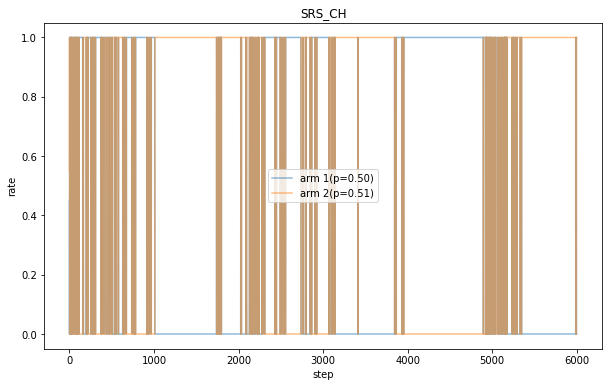

In [8]:
# p = [0.50, 0.51]
steps = 6000
simulata = Simulater(n_sim=1, steps=steps, arm_size=2, p = [0.50, 0.51], epsilon=10**-4)
regeret_SRS_CH, count_SRS =  simulata.test(SRS_CH, Agent)

arm_1_srs_ch = np.zeros(steps)
arm_2_srs_ch = np.zeros(steps)

for j in range(steps):
  arm_1_srs_ch[j] = count_SRS[j][0]/1000
  arm_2_srs_ch[j] = count_SRS[j][1]/1000

# 選択確率
print("p=0.50\n",arm_1_srs_ch[:100],"\n\n")
print("p=0.51\n",arm_2_srs_ch[:100])

plt.figure(figsize=(10,6))
plt.xlabel("step")
plt.ylabel("regret")
plt.plot(np.mean(regeret_SRS_CH, axis=0), label="SRS-CH(ℵ=p1)")
plt.title("n_sim=1000, steps=1000, arm_size=2, ε=10**-4")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.xlabel("step")
plt.ylabel("rate")
plt.plot(arm_1_srs_ch, label = "arm 1(p=0.50)", alpha = 0.5)
plt.plot(arm_2_srs_ch, label = "arm 2(p=0.51)", alpha = 0.5)
plt.title("SRS_CH")
plt.legend()
plt.show()

## ε

100%|██████████| 6000/6000 [03:55<00:00, 25.46it/s]


p=0.45
 [0.492 0.    0.496 0.376 0.    0.    1.    1.    0.495 0.    0.507 0.
 0.506 0.    1.    1.    0.469 1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    0.    1.    1.    1.    1.
 0.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    0.    0.    0.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.   ] 


p=0.55
 [0.508 1.    0.504 0.624 1.    1.    0.    0.    0.505 1.    0.493 1.
 0.494 1.    0.    0.    0.531 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    1.    1.    1.    0.
 0.    0.    0.    0.    0.    0.    0.    0.

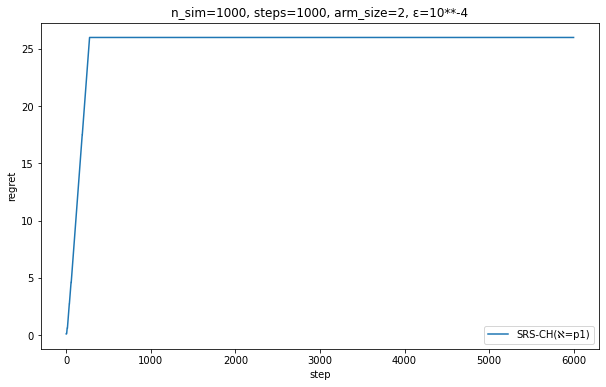

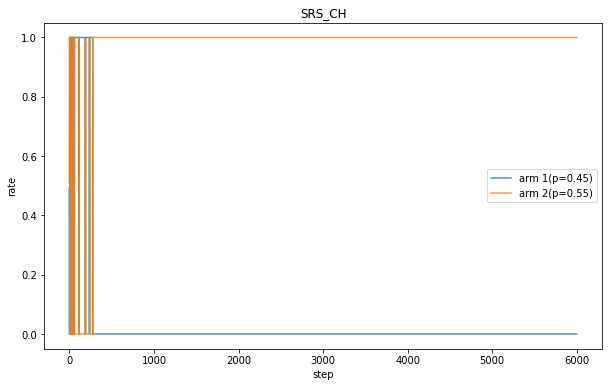

In [9]:
# p = [0.45, 0.55]
steps = 6000
simulata = Simulater(n_sim=1, steps=steps, arm_size=2, p = [0.45, 0.55], epsilon=10**-5)
regeret_SRS_CH, count_SRS =  simulata.test(SRS_CH, Agent)

arm_1_srs_ch = np.zeros(steps)
arm_2_srs_ch = np.zeros(steps)

for j in range(steps):
  arm_1_srs_ch[j] = count_SRS[j][0]/1000
  arm_2_srs_ch[j] = count_SRS[j][1]/1000

# 選択確率
print("p=0.45\n",arm_1_srs_ch[:100],"\n\n")
print("p=0.55\n",arm_2_srs_ch[:100])

plt.figure(figsize=(10,6))
plt.xlabel("step")
plt.ylabel("regret")
plt.plot(np.mean(regeret_SRS_CH, axis=0), label="SRS-CH(ℵ=p1)")
plt.title("n_sim=1000, steps=1000, arm_size=2, ε=10**-4")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.xlabel("step")
plt.ylabel("rate")
plt.plot(arm_1_srs_ch, label = "arm 1(p=0.45)", alpha = 0.8)
plt.plot(arm_2_srs_ch, label = "arm 2(p=0.55)", alpha = 0.8)
plt.title("SRS_CH")
plt.legend()
plt.show()

100%|██████████| 6000/6000 [03:55<00:00, 25.50it/s]


p=0.45
 [0.493 0.    0.527 1.    0.    0.    1.    0.    1.    0.    0.    1.
 0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ] 


p=0.55
 [0.507 1.    0.473 0.    1.    1.    0.    1.    0.    1.    1.    0.
 1.    0.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    0.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.

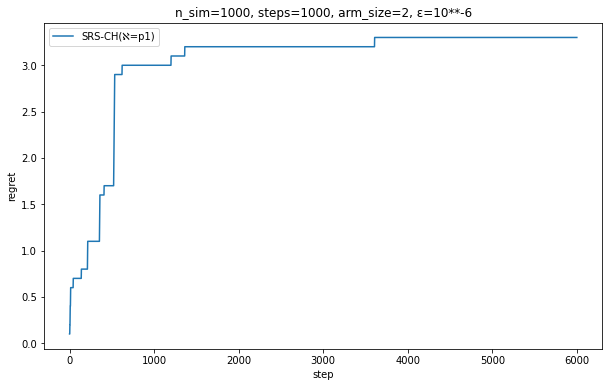

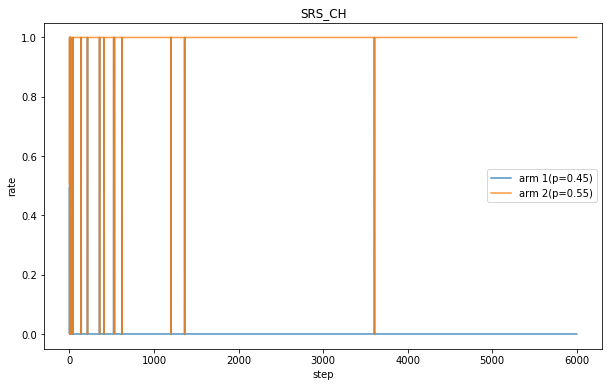

In [10]:
# p = [0.45, 0.55]
steps = 6000
simulata = Simulater(n_sim=1, steps=steps, arm_size=2, p = [0.45, 0.55], epsilon=10**-6)
regeret_SRS_CH, count_SRS =  simulata.test(SRS_CH, Agent)

arm_1_srs_ch = np.zeros(steps)
arm_2_srs_ch = np.zeros(steps)

for j in range(steps):
  arm_1_srs_ch[j] = count_SRS[j][0]/1000
  arm_2_srs_ch[j] = count_SRS[j][1]/1000

# 選択確率
print("p=0.45\n",arm_1_srs_ch[:100],"\n\n")
print("p=0.55\n",arm_2_srs_ch[:100])

plt.figure(figsize=(10,6))
plt.xlabel("step")
plt.ylabel("regret")
plt.plot(np.mean(regeret_SRS_CH, axis=0), label="SRS-CH(ℵ=p1)")
plt.title("n_sim=1000, steps=1000, arm_size=2, ε=10**-6")
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.xlabel("step")
plt.ylabel("rate")
plt.plot(arm_1_srs_ch, label = "arm 1(p=0.45)", alpha = 0.8)
plt.plot(arm_2_srs_ch, label = "arm 2(p=0.55)", alpha = 0.8)
plt.title("SRS_CH")
plt.legend()
plt.show()